# $\Phi$-SO demo : Class SR quick start

## Class SR definition

Class Symbolic Regression:  
Automatically finding a single analytical functional form that accurately fits multiple datasets - each governed by its own (possibly) unique set of fitting parameters.  
This hierarchical framework leverages the common constraint that all the members of a single class of physical phenomena follow a common governing law. 

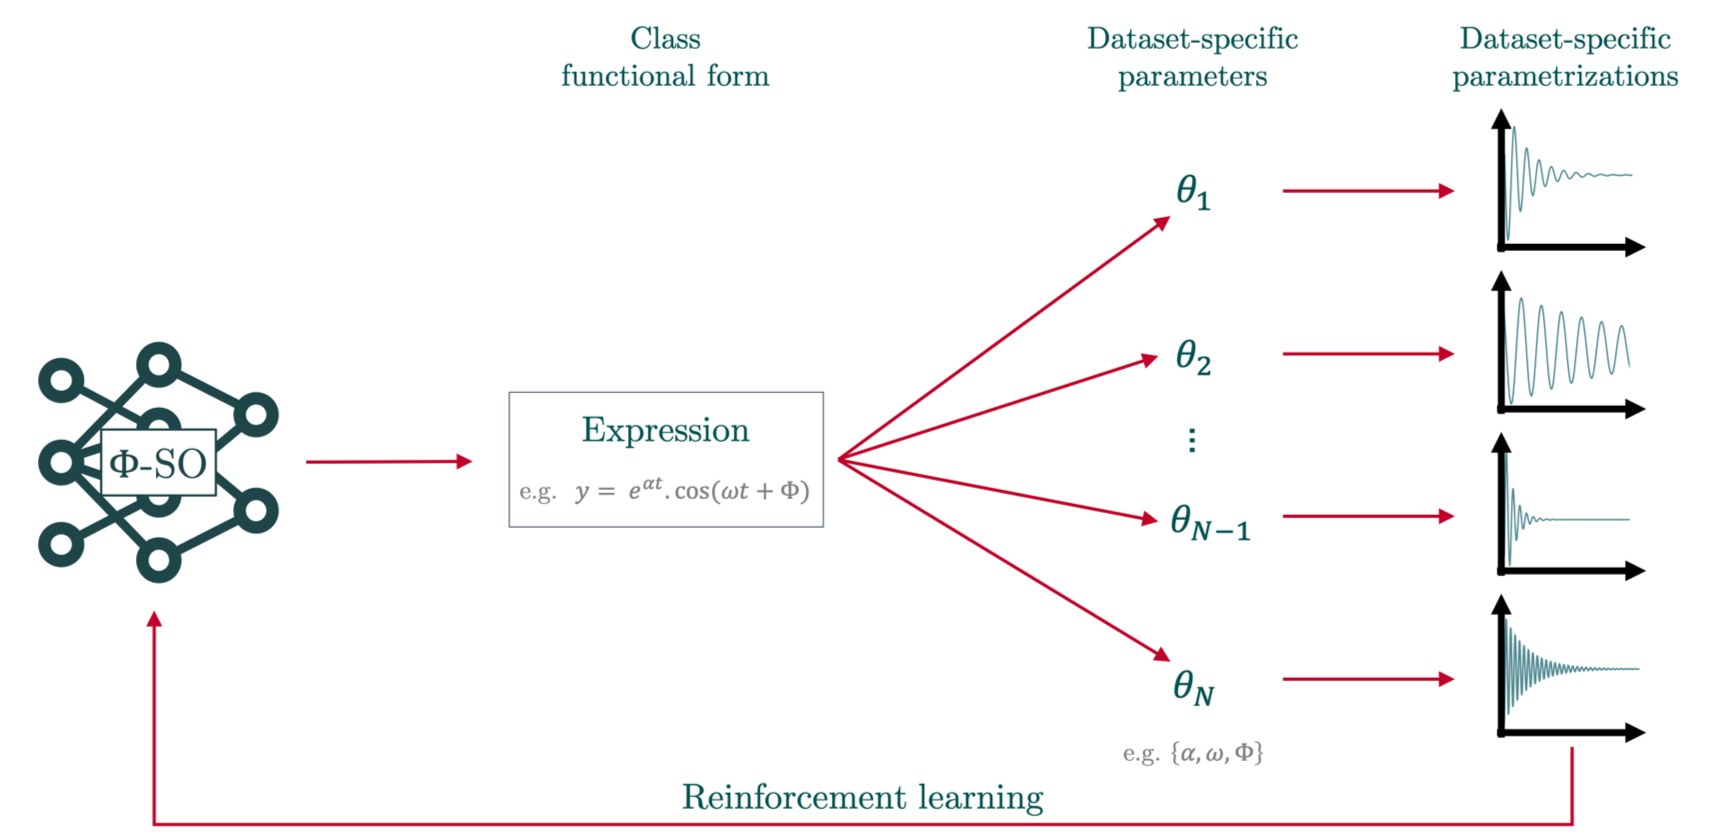

## Package import

In [1]:
# External packages
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
# Internal code import
import physo
import physo.learn.monitoring as monitoring

Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.

Multiprocessing start method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs available :  8
Recommended config {'parallel_mode': False, 'n_cpus': 8}
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn')

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/batch_execute.py:81: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:252: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


## Fixing seed

In [3]:
# Seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

## Dataset

Making toy synthetic datasets: here a simple 4 realizations linear problem where the numerical parameters governing the dependency on the x0 variable and the offset are different for each realization:

In [4]:
# Making toy synthetic data
multi_X = []
multi_y = []

# Realization 0
x0 = np.random.uniform(-10, 10, 256)
x1 = np.random.uniform(-10, 10, 256)
X = np.stack((x0, x1), axis=0)
y = 1.123*x0 + 1.123*x1 + 10.123
multi_X.append(X)
multi_y.append(y)

# Realization 1
x0 = np.random.uniform(-11, 11, 500)
x1 = np.random.uniform(-11, 11, 500)
X = np.stack((x0, x1), axis=0)
y = 2*1.123*x0 + 1.123*x1 + 10.123
multi_X.append(X)
multi_y.append(y)

# Realization 2
x0 = np.random.uniform(-12, 12, 256)
x1 = np.random.uniform(-12, 12, 256)
X = np.stack((x0, x1), axis=0)
y = 1.123*x0 + 1.123*x1 + 0.5*10.123
multi_X.append(X)
multi_y.append(y)

# Realization 3
x0 = np.random.uniform(-13, 13, 256)
x1 = np.random.uniform(-13, 13, 256)
X = np.stack((x0, x1), axis=0)
y = 0.5*1.123*x0 + 1.123*x1 + 2*10.123
multi_X.append(X)
multi_y.append(y)


Where `multi_X` and `multi_y` are lists containing $n_{reals}$ realizations (here $n_{reals}=4$). `multi_X` should contain $n_{reals}$ elements consisting of input variables values ($X$) (one per realization) and `multi_y` should contain $n_{reals}$ corresponding target values ($y$) (one per realization).
Elements $X$, $y$ should respectively be of shape $(n_{dim}, ?,)$ and $(?,)$ where $n_{dim}$ is the number of input variables (here $n_{dim}=2$ as there are 2 input variables: $\{x_0, x_1\}$) and `?` is the number of data points (this number must be consistent across each $\{X, y\}$ pair but can depend on the realization).

It should be noted that free constants search starts around 1. by default. Therefore when using default hyperparameters, normalizing the data around an order of magnitude of 1 is strongly recommended.

Dataset plot

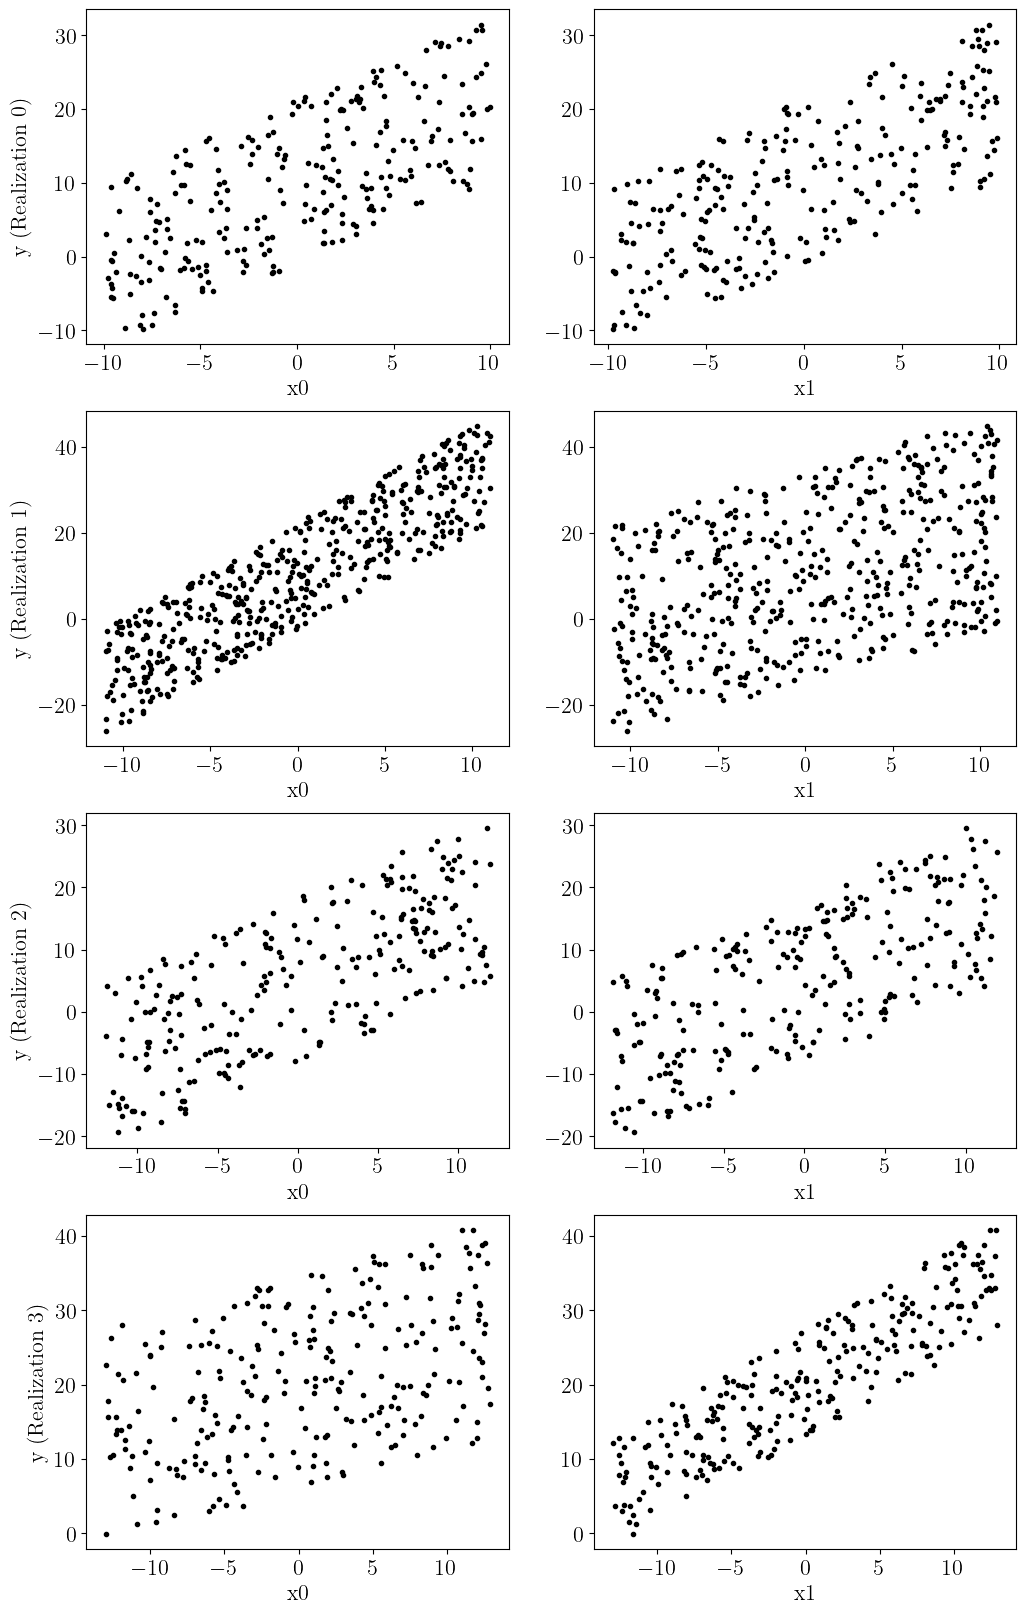

In [5]:
n_reals = len(multi_X)
fig, ax = plt.subplots(n_reals, 2, figsize=(12,20))

for i in range(n_reals):
    ax[i][0].plot(multi_X[i][0], multi_y[i], 'k.')
    ax[i][0].set_xlabel("x0")
    ax[i][0].set_ylabel("y (Realization %i)"%(i))
    ax[i][1].plot(multi_X[i][1], multi_y[i], 'k.')
    ax[i][1].set_xlabel("x1")


## Running Class SR task

### Available configurations

It should be noted that SR capabilities of `physo` are heavily dependent on hyperparameters, it is therefore recommended to tune hyperparameters to your own specific problem for doing science.  
Summary of currently available hyperparameters presets configurations:

|  Configuration    |            Recommended usecases                             |    Speed    |   Effectiveness   |                           Notes                                |
|:------------------:|:----------------------------------------------------------:|:-----------:|:-----------------:|:--------------------------------------------------------------:|
| `config0b`          | Demos                                                     |     ★★★     |         ★         | Light and fast config.                                         |
| `config1b`          | SR with DA $^*$ ;  Class SR with DA $^*$                    |      ★      |        ★★★        | Config used for Feynman Benchmark and MW streams Benchmark.    |
| `config2b`          | SR ; Class SR                                             |      ★★     |        ★★         | Config used for Class Benchmark.                               |

$^*$ DA = Dimensional Analysis

Users are encouraged to edit configurations (they can be found in: [physo/config/](https://github.com/WassimTenachi/PhySO/tree/main/physo/config)).  
By default, `config0b` is used, however it is recommended to follow the upper recommendations for doing science.

__Class SR side notes__:  

1. It is recommended to always use the `b` variant (ie. `configxb`) of configurations for Class SR as these variants specify a larger number of steps for the free constants optimizations that is performed during expression candidate evaluation (this is necessary because all free constants specific to each realization are optimized at the same time which typically makes it necessary to have a larger number of optimization steps).

2. Due to the typically higher number of free constants values to tune, Class SR is typically much more expansive computationally than regular SR, lower batch size configurations are therefore recommended.

__DA side notes__:   
1. During the first tens of iterations, the neural network is typically still learning the rules of dimensional analysis, resulting in most candidates being discarded and not learned on, effectively resulting in a much smaller batch size (typically 10x smaller), thus making the evaluation process much less computationally expensive. It is therefore recommended to compensate this behavior by using a higher batch size configuration which helps provide the neural network sufficient learning information.


### Logging config

Logging and visualisation setup:

In [6]:
save_path_training_curves = 'demo_curves.png'
save_path_log             = 'demo.log'

run_logger     = lambda : monitoring.RunLogger(save_path = save_path_log,
                                                do_save = True)

run_visualiser = lambda : monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

__Class SR run__ :  

Automatically finding a single analytical functional form that accurately fits multiple datasets - each governed by its own (possibly) unique set of fitting parameters.  
This hierarchical framework leverages the common constraint that all the members of a single class of physical phenomena follow a common governing law.  

Ie. recovering a single analytical function $f$ that best fits $y_{i_{real}} = f_{i_{real}}(x_0, ..., x_{n_{dim}})$ for each realization $i_{real} \leq n_{reals}$ of a phenomena given $\{\{x_0, ..., x_{n_{dim}}\}_{i_{real}}\}_{i_{real} \leq n_{reals}}$ (`multi_X`) data and $\{y_{i_{real}}\}_{i_{real} \leq n_{reals}}$ (`multi_y`) data.  
Realization-specific free constants ie. free constants taking different values depending on the realization ($\{k_0, k_1, ...\}_{i_{real} \leq n_{reals}}$) are designated as `spe_free_consts` and free constants common to the whole class ($\{c_0, c_1, ...\}$) are designated as `class_free_consts`.

### Run

Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
SR task started...


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/batch_execute.py:81: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['exp'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred wh

=========== Epoch 00000 ===========
-> Time 1.52 s
-> Memory Usage: 620.42 MB

Overall best  at R=0.785930
-> Raw expression : 
   ⎛        k₀ + k₀ + k₁⋅1.0 - x₀⎞
k₁⋅⎜k₁⋅x₁ - ─────────────────────⎟
   ⎝                 c₀          ⎠

Best of epoch at R=0.785930
-> Raw expression : 
   ⎛        k₀ + k₀ + k₁⋅1.0 - x₀⎞
k₁⋅⎜k₁⋅x₁ - ─────────────────────⎟
   ⎝                 c₀          ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['exp'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['log'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_phy

=========== Epoch 00001 ===========
-> Time 54.16 s
-> Memory Usage: 478.33 MB

Overall best  at R=0.834803
-> Raw expression : 
k₀⋅(c₀⋅(c₀⋅c₀⋅x₀ + x₁) + k₁ - 1.0) + k₀

Best of epoch at R=0.834803
-> Raw expression : 
k₀⋅(c₀⋅(c₀⋅c₀⋅x₀ + x₁) + k₁ - 1.0) + k₀




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['exp'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['log'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_phy

=========== Epoch 00002 ===========
-> Time 62.98 s
-> Memory Usage: 635.14 MB

Overall best  at R=0.943423
-> Raw expression : 
x₁ - (c₀⋅k₁⋅x₀ - k₀)
────────────────────
        1.0         

Best of epoch at R=0.943423
-> Raw expression : 
x₁ - (c₀⋅k₁⋅x₀ - k₀)
────────────────────
        1.0         




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['exp'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['log'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_phy

=========== Epoch 00003 ===========
-> Time 65.64 s
-> Memory Usage: 623.03 MB

Overall best  at R=0.943423
-> Raw expression : 
x₁ - (c₀⋅k₁⋅x₀ - k₀)
────────────────────
        1.0         

Best of epoch at R=0.943423
-> Raw expression : 
             x₀ 
k₀ + k₁⋅x₁ + ───
             1.0
────────────────
       k₁       




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['exp'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['log'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_phy

=========== Epoch 00004 ===========
-> Time 86.68 s
-> Memory Usage: 571.89 MB

Overall best  at R=0.943423
-> Raw expression : 
x₁ - (c₀⋅k₁⋅x₀ - k₀)
────────────────────
        1.0         

Best of epoch at R=0.943423
-> Raw expression : 
                       ⎛c₀     ⎞
-k₀⋅x₀ - x₀ + x₁ + 1.0⋅⎜── - k₀⎟
                       ⎝k₁     ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['exp'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['log'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_phy

=========== Epoch 00005 ===========
-> Time 83.04 s
-> Memory Usage: 621.62 MB

Overall best  at R=0.943423
-> Raw expression : 
x₁ - (c₀⋅k₁⋅x₀ - k₀)
────────────────────
        1.0         

Best of epoch at R=0.943423
-> Raw expression : 
      ⎛   k₀         ⎞     
k₁⋅x₁⋅⎜───────── + x₀⎟     
      ⎜⎛  c₀   ⎞     ⎟     
      ⎜⎜───────⎟     ⎟     
      ⎝⎝k₀ + k₁⎠     ⎠     
────────────────────── + x₁
          x₁               




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['exp'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['log'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_phy

=========== Epoch 00006 ===========
-> Time 52.77 s
-> Memory Usage: 452.09 MB

Overall best  at R=0.951286
-> Raw expression : 
-k₀ + k₁⋅(-c₀⋅x₀ + x₁) - k₁ + x₀ + x₁

Best of epoch at R=0.951286
-> Raw expression : 
-k₀ + k₁⋅(-c₀⋅x₀ + x₁) - k₁ + x₀ + x₁




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['exp'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['log'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_phy

=========== Epoch 00007 ===========
-> Time 53.30 s
-> Memory Usage: 639.64 MB

Overall best  at R=1.000000
-> Raw expression : 
c₀⋅(c₀⋅(k₀⋅x₀ + x₁ + 1.0) - c₀ + k₁ + 1.0)

Best of epoch at R=1.000000
-> Raw expression : 
c₀⋅(c₀⋅(k₀⋅x₀ + x₁ + 1.0) - c₀ + k₁ + 1.0)




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['exp'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['log'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_phy

=========== Epoch 00008 ===========
-> Time 54.35 s
-> Memory Usage: 641.08 MB

Overall best  at R=1.000000
-> Raw expression : 
c₀⋅(c₀⋅(k₀⋅x₀ + x₁ + 1.0) - c₀ + k₁ + 1.0)

Best of epoch at R=0.943423
-> Raw expression : 
c₀ + k₀⋅(c₀ - x₀ + 1.0) + k₀ + k₁ + k₁ + x₁




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['exp'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/prior.py:870: UserWarning: An error occurred while making prior NestedFunctions, this prior will be ignored. Error message:
Some tokens given in argument functions: ['log'] are not in the library of tokens: ['add' 'sub' 'mul' 'div' '1.0' 'c0' 'k0' 'k1' 'x0' 'x1' 'y' 'dummy' '-']
  warnings.warn("An error occurred while making prior %s, this prior will be ignored. "
/Users/wtenachi/Documents/ASTRO_research/projects/AI_phy

=========== Epoch 00009 ===========
-> Time 55.13 s
-> Memory Usage: 633.06 MB

Overall best  at R=1.000000
-> Raw expression : 
c₀⋅(c₀⋅(k₀⋅x₀ + x₁ + 1.0) - c₀ + k₁ + 1.0)

Best of epoch at R=1.000000
-> Raw expression : 
k₁ - (c₀⋅x₁ + c₀ + c₀ + k₀⋅x₀ + x₀)




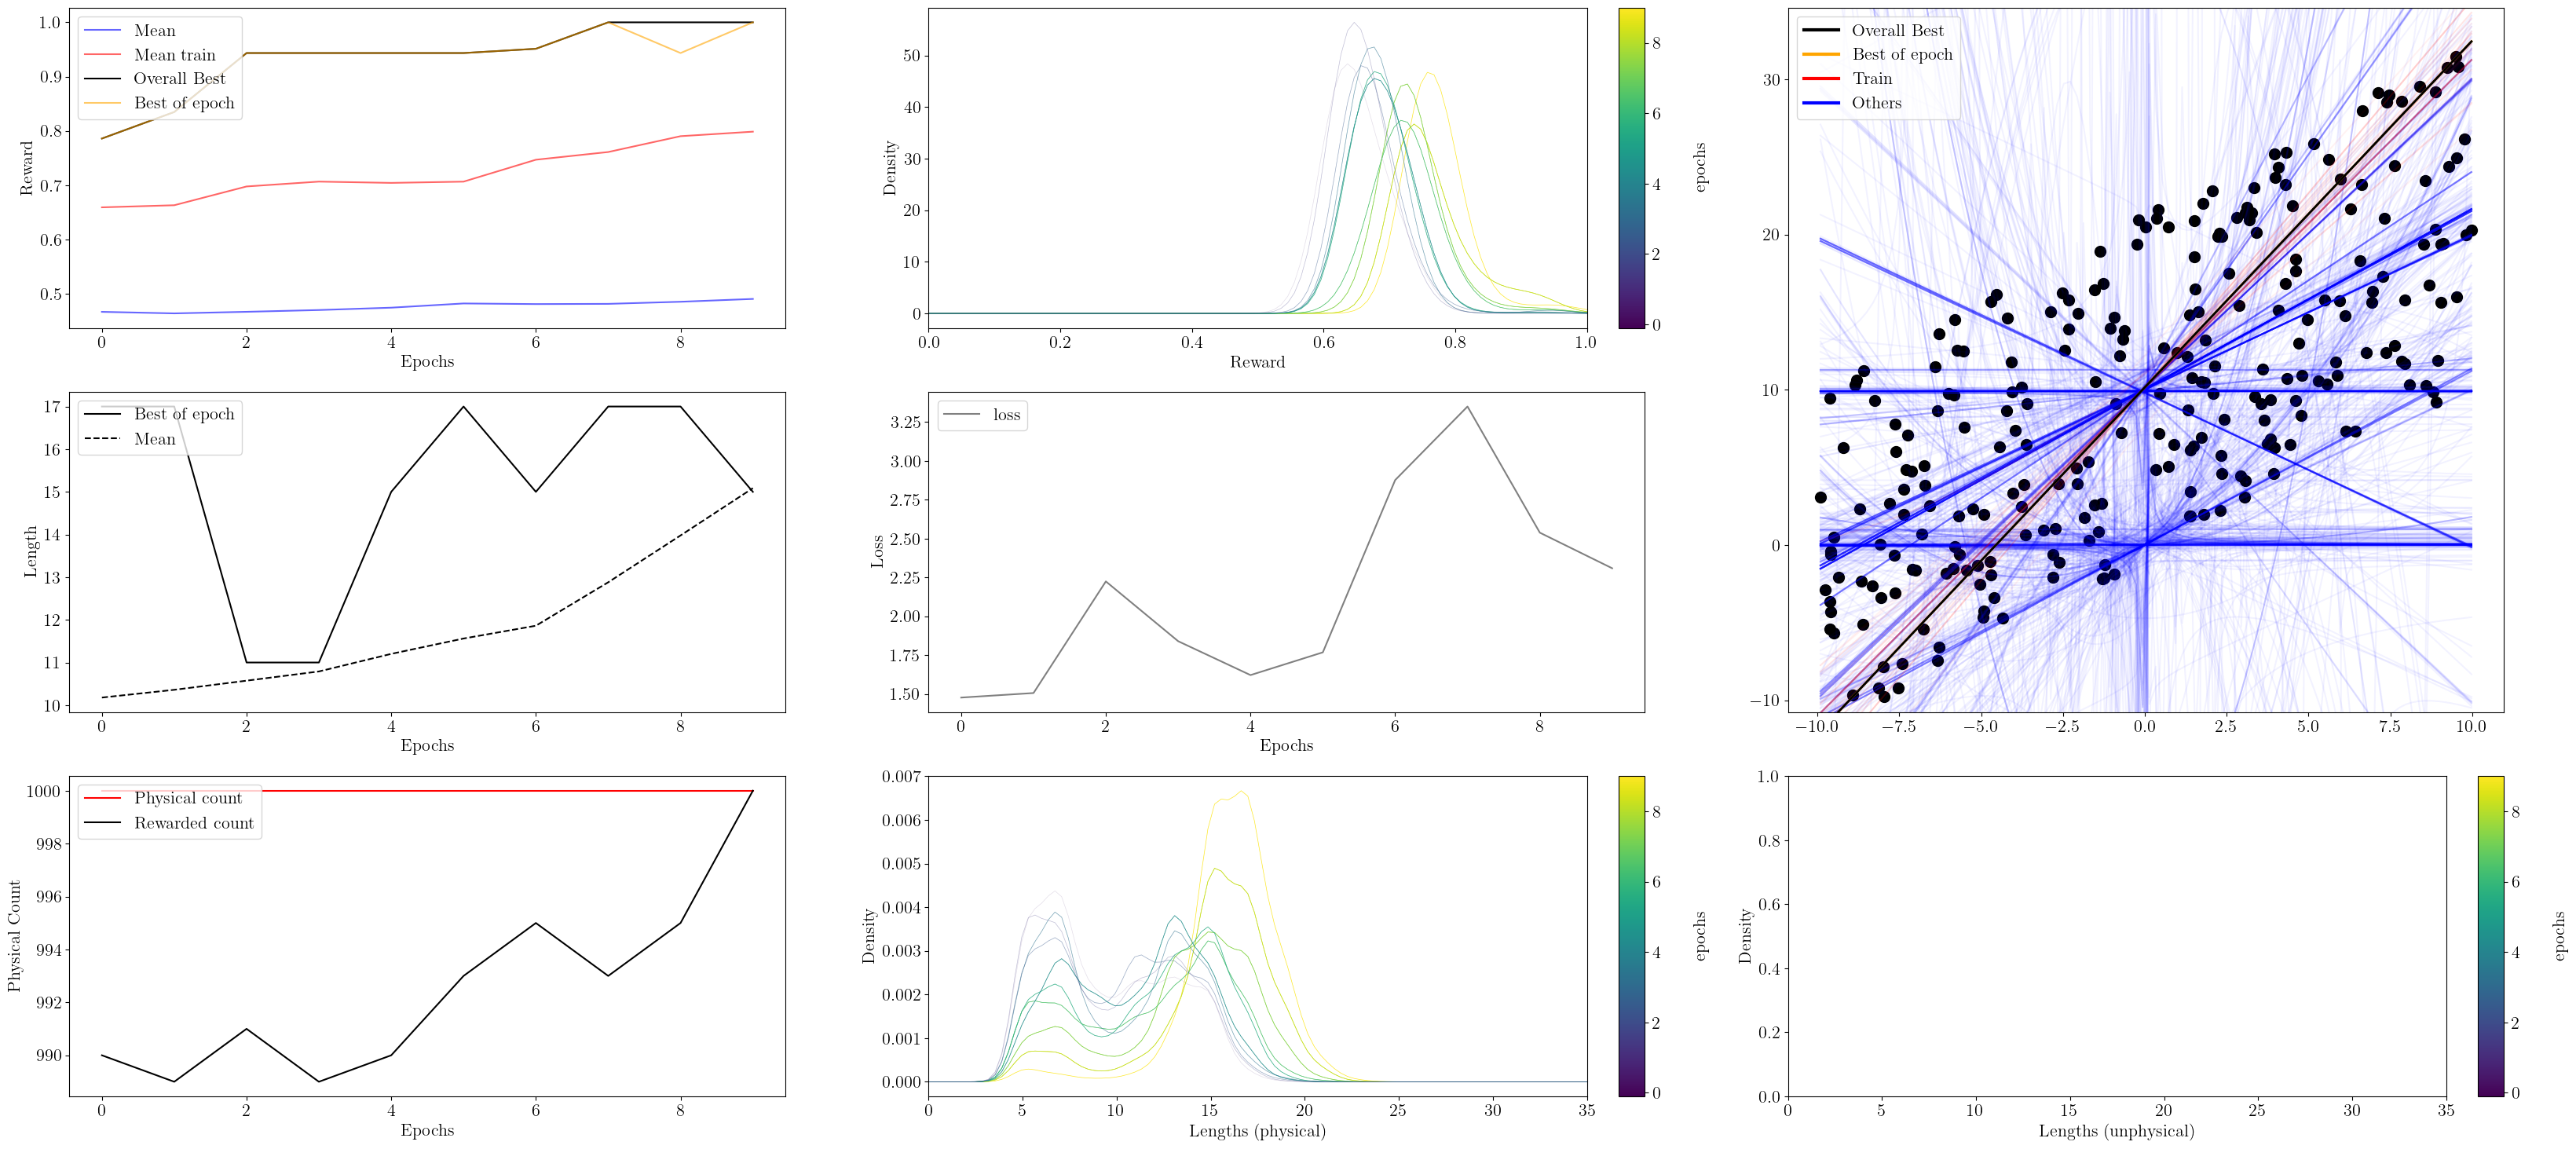

In [7]:
# Running SR task
expression, logs = physo.ClassSR(multi_X, multi_y,
                            # Giving names of variables (for display purposes)
                            X_names = [ "x0"       , "x1"        ],
                            # Associated physical units (ignore or pass zeroes if irrelevant)
                            X_units = [ [0, 0, 0] , [0, 0, 0]    ],
                            # Giving name of root variable (for display purposes)
                            y_name  = "y",
                            y_units = [0, 0, 0],
                            # Fixed constants
                            fixed_consts       = [ 1.      ],
                            fixed_consts_units = [ [0, 0, 0] ],
                            # Whole class free constants
                            class_free_consts_names = [ "c0"      ,],
                            class_free_consts_units = [ [0, 0, 0] ,],
                            # Realization specific free constants
                            spe_free_consts_names = [ "k0"      , "k1"        ],
                            spe_free_consts_units = [ [0, 0, 0] , [0, 0, 0]   ],
                            # Run config
                            run_config = physo.config.config0b.config0b,
                            # Symbolic operations that can be used to make f
                            op_names = ["add", "sub", "mul", "div"],
                            get_run_logger     = run_logger,
                            get_run_visualiser = run_visualiser,
                            # Parallel mode (only available when running from python scripts, not notebooks)
                            parallel_mode = False,
                            # Number of iterations
                            epochs = 10,
)



## Inspecting the best expression found

### Getting best expression 

The best expression found (in accuracy) is returned in the `expression` variable:

In [8]:
best_expr = expression
print(best_expr.get_infix_pretty())

c₀⋅(c₀⋅(k₀⋅x₀ + x₁ + 1.0) - c₀ + k₁ + 1.0)


It can also be loaded later on from log files:

In [9]:
import physo
from physo.benchmark.utils import symbolic_utils as su
import sympy

# Loading pareto front expressions
pareto_expressions = physo.read_pareto_pkl("demo_curves_pareto.pkl")
# Most accurate expression is the last in the Pareto front:
best_expr = pareto_expressions[-1]
print(best_expr.get_infix_pretty())

c₀⋅(c₀⋅(k₀⋅x₀ + x₁ + 1.0) - c₀ + k₁ + 1.0)


### Display

The expression can be converted into...  
A sympy expression:

In [10]:
best_expr.get_infix_sympy()

c0*(c0*(k0*x0 + x1 + 1.0) - c0 + k1 + 1.0)

A sympy expression (with evaluated free constants values):

In [11]:
# In Class SR this will return an array of expression each containing constants values specific to each realization: 
best_expr.get_infix_sympy(evaluate_consts=True)

array([1.12299994574922*x0 + 1.12300000059904*x1 + 10.1229899722332,
       2.2460000470765*x0 + 1.12300000059904*x1 + 10.1229992016201,
       1.1230000011019*x0 + 1.12300000059904*x1 + 5.06150350622027,
       0.561500204424919*x0 + 1.12300000059904*x1 + 20.2460055721278],
      dtype=object)

A latex string:

In [12]:
best_expr.get_infix_latex()

'c_{0} \\left(c_{0} k_{0} x_{0} + c_{0} x_{1} + k_{1} + 1\\right)'

A latex string (with evaluated free constants values):

In [13]:
sympy.latex(best_expr.get_infix_sympy(evaluate_consts=True))

'\\mathtt{\\text{[1.12299994574922*x0 + 1.12300000059904*x1 + 10.1229899722332\n 2.2460000470765*x0 + 1.12300000059904*x1 + 10.1229992016201\n 1.1230000011019*x0 + 1.12300000059904*x1 + 5.06150350622027\n 0.561500204424919*x0 + 1.12300000059904*x1 + 20.2460055721278]}}'

### Getting free constant values

In [14]:
best_expr.free_consts

FreeConstantsTable
 -> Class consts (['c0']) : (1, np.int64(1))
 -> Spe consts   (['k0' 'k1']) : (1, np.int64(2), 4)

Class free constants

In [15]:
best_expr.free_consts.class_values

tensor([[1.0597]], dtype=torch.float64)

Realization-specific free constants

In [16]:
best_expr.free_consts.spe_values

tensor([[[ 1.0000,  2.0000,  1.0000,  0.5000],
         [ 8.5525,  8.5526,  3.7763, 18.1051]]], dtype=torch.float64)

### Checking exact symbolic recovery

In [17]:
# To sympy
best_expr = best_expr.get_infix_sympy(evaluate_consts=True)

best_expr = best_expr[0] # Considering the expression with its constants set for realization no 0 (Class SR)

# Printing best expression simplified and with rounded constants
print("best_expr : ", su.clean_sympy_expr(best_expr, round_decimal = 4))

# Target expression was:
target_expr = sympy.parse_expr("1.123*x0 + 1.123*x1 + 10.123")
print("target_expr : ", su.clean_sympy_expr(target_expr, round_decimal = 4))

# Check equivalence
print("\nChecking equivalence:")
is_equivalent, log = su.compare_expression(
                        trial_expr  = best_expr,
                        target_expr = target_expr,
                        handle_trigo            = True,
                        prevent_zero_frac       = True,
                        prevent_inf_equivalence = True,
                        verbose                 = True,
)
print("Is equivalent:", is_equivalent)

best_expr :  1.123*x0 + 1.123*x1 + 10.123
target_expr :  1.123*x0 + 1.123*x1 + 10.123

Checking equivalence:
  -> Assessing if 1.123*x0 + 1.123*x1 + 10.123 (target) is equivalent to 1.12299994574922*x0 + 1.12300000059904*x1 + 10.1229899722332 (trial)
   -> Simplified expression : 1.12*x0 + 1.12*x1 + 10.12
   -> Symbolic error        : 0
   -> Symbolic fraction     : 1
   -> Trigo symbolic error        : 0
   -> Trigo symbolic fraction     : 1
   -> Equivalent : True
Is equivalent: True
